In [1]:
import time
import random
import os
import mxnet as mx
import numpy as np
from mxnet import gluon, autograd ,nd
#np.set_printoptions(precision=2)
from PIL import Image

from mxnet.gluon import nn, Block, HybridBlock, Parameter, ParameterDict
import mxnet.ndarray as F

import utils
from tqdm import tqdm

## neural style transfer
### 구현 원리
- 기존에 알려진 VGG 19에서 각각의 convolutiuon layer 의미를 살펴보면 앞 부분의 conv는 이미지의 전체 style과 연관이 높으며 뒤로 갈 수록 이미지의 형태(content)와 연관이 높음을 확인 할 수 있다
- 해당 원리를 이용해서 우리가 원하는 style 이미지에 대해 앞 부분에서의 conv 부분만 추출하여 style에 대한 loss를 생성하여서 style을 학습하도록 한다
- 이 때 원래 이미지의 형태는 변하면 되지 않기 때문에 원래 이미지에 대해 content에 대한 conv 부분만을 추출하여서 content에 대한 loss 를 산출
- style loss와 content loss에 적당한 weight를 주어서 전체 loss를 산출
- 해당 loss를 최소화하도록 하여 content image를 학습 시킴

In [2]:
ctx = mx.gpu(0)

In [40]:
os.getcwd()

'/home/seunghwan/work/notebook/gluon_example/neural_transfer'

In [54]:
## 이미지 데이터 loading
content_image_path = os.getcwd()+'/images/eva.jpg'
style_image_path = os.getcwd() + '/images/picasso.jpg'
output_image_path = os.getcwd() + '/output2.jpg'
content_size = 450
style_size = 450
lr = 1e1
content_weight = 100.0
style_weight = 10000.0
num_iteration = 500

In [5]:
def load_rgbimage(filename, ctx, size=None, scale=None, keep_asp=False):
    img = Image.open(filename).convert('RGB')
    if size is not None:
        if keep_asp:
            size2 = int(size * 1.0 / img.size[0] * img.size[1])
            img = img.resize((size, size2), Image.ANTIALIAS)
        else:
            img = img.resize((size, size), Image.ANTIALIAS)

    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.ANTIALIAS)
    img = np.array(img).transpose(2, 0, 1).astype(float)
    img = F.expand_dims(mx.nd.array(img, ctx=ctx), 0)
    return img

In [6]:
def show_image_rgb(data):
    (r, g, b) = nd.split(data[0], num_outputs=3, axis=0)
    img = F.concat(r, g, b, dim=0)
    img = F.clip(img, 0, 255).asnumpy()
    img = img.transpose(1, 2, 0).astype('uint8')
    img = Image.fromarray(img)
    return img

In [7]:
##image data loading..
content_image = load_rgbimage(content_image_path,ctx, size=content_size, keep_asp=True)
style_image = load_rgbimage(style_image_path, ctx, size=style_size)

In [8]:
content_image.shape

(1, 3, 638, 450)

In [9]:
style_image.shape

(1, 3, 450, 450)

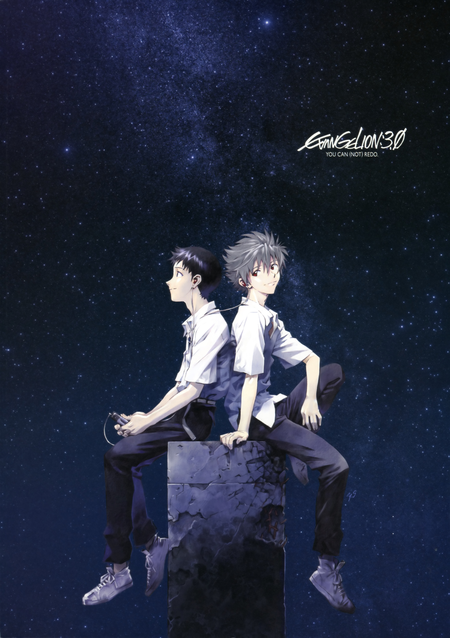

In [10]:
#show original image
show_image_rgb(content_image)

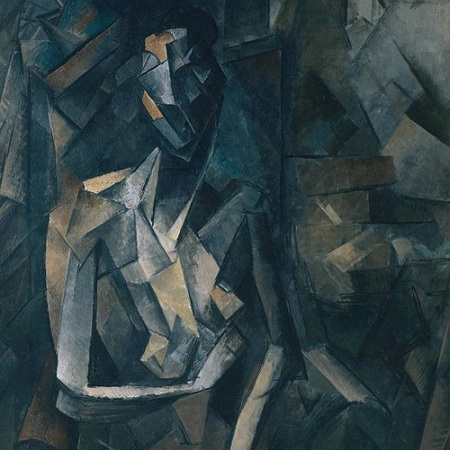

In [11]:
#show style image
show_image_rgb(style_image)

In [ ]:
### Style transfer 구현 원리

In [12]:
vgg_layers = mx.gluon.model_zoo.vision.vgg19(pretrained=True,ctx=ctx).features

In [13]:
vgg_layers

HybridSequential(
  (0): Conv2D(3 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Activation(relu)
  (2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Activation(relu)
  (4): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (5): Conv2D(64 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): Activation(relu)
  (7): Conv2D(128 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): Activation(relu)
  (9): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (10): Conv2D(128 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): Activation(relu)
  (12): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): Activation(relu)
  (14): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): Activation(relu)
  (16): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): Activation(relu)
  (18): MaxPool2

In [14]:
class LossNetwork(gluon.Block):
    def __init__(self,**kwargs):
        super(LossNetwork,self).__init__(**kwargs)
        with self.name_scope():
            self.vgg_layers = mx.gluon.model_zoo.vision.vgg16(pretrained=True,ctx=ctx).features
            ## conv_1, conv_2, conv_3, conv_4, conv_5는  style loss 산출에 사용
            ## conv_4의 경우에는 content loss 산출에 사용
            self.layer_name_mapping = {
            '0': "conv_1",
            '2': "conv_2",
            '5': "conv_3",
            '7': "conv_4",
            '10': "conv_5"   
        }
    
    def forward(self,x):
        output ={}
        output = []
        ## conv layer 부분만 추출
        for i in range(31):
            #print(i)
            x = self.vgg_layers[i](x)
            if str(i) in self.layer_name_mapping:
                #output[self.layer_name_mapping[str(i)]] = x
                output.append(x)
        #return LossOutput(**output)
        return output

### gram matrix
- feature 간의 correlation을 산출하기 위해 제시한 matrix
- channel(feature)을 기준으로 하여 inner product를 수행


In [15]:
def gram_matrix(y):
    (b, ch, h, w) = y.shape
    features = y.reshape((b, ch, w * h))
    #features_t = F.SwapAxis(features,1, 2)
    gram = F.batch_dot(features, features, transpose_b=True) / (ch * h * w)
    return gram

In [60]:
tmp = nd.random_normal(0,1,shape=(1,128,250,300))

In [61]:
tmp.shape

(1, 128, 250, 300)

In [62]:
tmp_gram = gram_matrix(tmp)

In [63]:
tmp_gram.shape

(1, 128, 128)

In [16]:
# load the pre-trained vgg-19 and extract features
vgg = LossNetwork()

In [17]:
# content feature
f_xc_c = vgg(content_image)[3]
# style feature
features_style = vgg(style_image)
#style 을 기준으로 하여 gram matrix  산출
gram_style = [gram_matrix(y) for y in features_style]

# output
# gradient 값을 기준으로 하여 input image를 변화 시켜야 함 -->  input image를 parameter 형태로 변환하여  gradient 값을 바탕으로 update가 이루어지도록 함
output = Parameter('output', shape=content_image.shape)
output.initialize(ctx=ctx)
output.set_data(content_image.copy())
# optimizer
trainer = gluon.Trainer([output], 'adam', {'learning_rate': lr})
mse_loss = gluon.loss.L2Loss()

In [18]:
iter_loss = dict()
iter_loss['style'] =[]
iter_loss['content'] =[]

# optimizing the images
for e in tqdm(range(num_iteration)):
    utils.imagenet_clamp_batch(output.data(), 0, 255)
    # fix BN for pre-trained vgg
    with autograd.record():
        features_y = vgg(output.data())
        content_loss = 2 * content_weight * mse_loss(features_y[3], f_xc_c)
        style_loss = 0.
        for m in range(len(features_y)):
            #gram_y = net.gram_matrix(features_y[m])
            gram_y = gram_matrix(features_y[m])
            gram_s = gram_style[m]
            style_loss = style_loss + 2 * style_weight * mse_loss(gram_y, gram_s)
        total_loss = content_loss + style_loss
        total_loss.backward()
    if (e + 1) % 10 == 0:
        iter_loss['style'].append(style_loss.asscalar())
        iter_loss['content'].append(content_loss.asscalar())
        
    
    trainer.step(1)
    #if (e + 1) % 50 == 0:
    #    print('loss:{:.2f}'.format(total_loss.asnumpy()[0]))

100%|██████████| 500/500 [00:35<00:00, 14.04it/s]


/home/seunghwan/work/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


/home/seunghwan/work/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


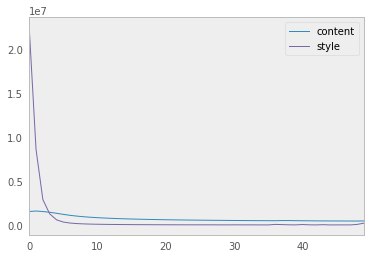

In [19]:
#style/transfer loss plot
import pandas as pd
import matplotlib as mpl
%matplotlib inline 
pd.options.display.mpl_style = 'default'
new_style = {'grid': False}
mpl.rc('axes', **new_style)
data = pd.DataFrame.from_dict(iter_loss)
data.plot()

In [20]:
#conv_data = utils.add_imagenet_mean_batch(output.data())
conv_data = output.data()

In [21]:
conv_data.shape

(1, 3, 638, 450)

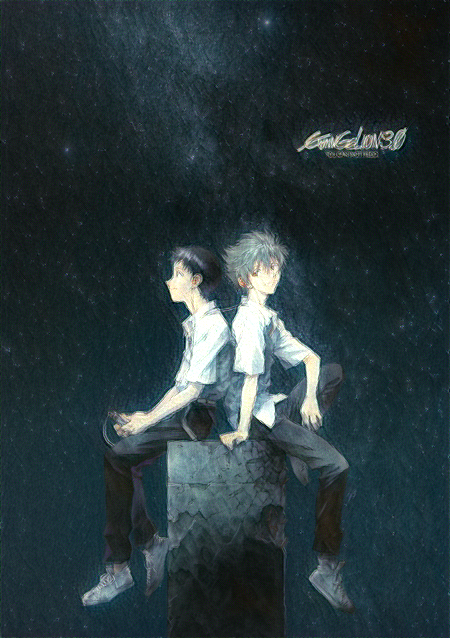

In [22]:
#show changed image
show_image_rgb(conv_data)